In [5]:
import math
from torch import nn


class ESPCN(nn.Module):
    def __init__(self, scale_factor, num_channels=1):
        super(ESPCN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=5, padding=5//2),
            nn.Tanh(),
            nn.Conv2d(64, 32, kernel_size=3, padding=3//2),
            nn.Tanh(),
        )
        self.last_part = nn.Sequential(
            nn.Conv2d(32, num_channels * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
            # nn.Conv2d(32, num_channels, kernel_size=3, padding=3 // 2),
            nn.PixelShuffle(scale_factor)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.in_channels == 32:
                    nn.init.normal_(m.weight.data, mean=0.0, std=0.001)
                    nn.init.zeros_(m.bias.data)
                else:
                    nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                    nn.init.zeros_(m.bias.data)

    def forward(self, x):
        x = self.first_part(x)
        x = self.last_part(x)
        return x

In [3]:
import torch
import numpy as np


def calc_patch_size(func):
    def wrapper(args):
        if args.scale == 2:
            args.patch_size = 10
        elif args.scale == 3:
            args.patch_size = 7
        elif args.scale == 4:
            args.patch_size = 6
        else:
            raise Exception('Scale Error', args.scale)
        return func(args)
    return wrapper


def convert_rgb_to_y(img, dim_order='hwc'):
    if dim_order == 'hwc':
        return 16. + (64.738 * img[..., 0] + 129.057 * img[..., 1] + 25.064 * img[..., 2]) / 256.
    else:
        return 16. + (64.738 * img[0] + 129.057 * img[1] + 25.064 * img[2]) / 256.


def convert_rgb_to_ycbcr(img, dim_order='hwc'):
    if dim_order == 'hwc':
        y = 16. + (64.738 * img[..., 0] + 129.057 * img[..., 1] + 25.064 * img[..., 2]) / 256.
        cb = 128. + (-37.945 * img[..., 0] - 74.494 * img[..., 1] + 112.439 * img[..., 2]) / 256.
        cr = 128. + (112.439 * img[..., 0] - 94.154 * img[..., 1] - 18.285 * img[..., 2]) / 256.
    else:
        y = 16. + (64.738 * img[0] + 129.057 * img[1] + 25.064 * img[2]) / 256.
        cb = 128. + (-37.945 * img[0] - 74.494 * img[1] + 112.439 * img[2]) / 256.
        cr = 128. + (112.439 * img[0] - 94.154 * img[1] - 18.285 * img[2]) / 256.
    return np.array([y, cb, cr]).transpose([1, 2, 0])


def convert_ycbcr_to_rgb(img, dim_order='hwc'):
    if dim_order == 'hwc':
        r = 298.082 * img[..., 0] / 256. + 408.583 * img[..., 2] / 256. - 222.921
        g = 298.082 * img[..., 0] / 256. - 100.291 * img[..., 1] / 256. - 208.120 * img[..., 2] / 256. + 135.576
        b = 298.082 * img[..., 0] / 256. + 516.412 * img[..., 1] / 256. - 276.836
    else:
        r = 298.082 * img[0] / 256. + 408.583 * img[2] / 256. - 222.921
        g = 298.082 * img[0] / 256. - 100.291 * img[1] / 256. - 208.120 * img[2] / 256. + 135.576
        b = 298.082 * img[0] / 256. + 516.412 * img[1] / 256. - 276.836
    return np.array([r, g, b]).transpose([1, 2, 0])


def preprocess(img, device):
    img = np.array(img).astype(np.float32)
    ycbcr = convert_rgb_to_ycbcr(img)
    x = ycbcr[..., 0]
    x /= 255.
    x = torch.from_numpy(x).to(device)
    x = x.unsqueeze(0).unsqueeze(0)
    return x, ycbcr


def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
import h5py
import numpy as np
from torch.utils.data import Dataset


class TrainDataset(Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][idx] / 255., 0), np.expand_dims(f['hr'][idx] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])


class EvalDataset(Dataset):
    def __init__(self, h5_file):
        super(EvalDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][str(idx)][:, :] / 255., 0), np.expand_dims(f['hr'][str(idx)][:, :] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch: 0/49: : 21910it [02:21, 154.64it/s, loss=0.002480]


eval psnr: 33.78


epoch: 1/49: : 21910it [02:27, 148.99it/s, loss=0.000849]                       


eval psnr: 32.91


epoch: 2/49: : 21910it [02:34, 141.85it/s, loss=0.000779]                       


eval psnr: 33.88


epoch: 3/49: : 21910it [02:38, 138.34it/s, loss=0.000757]                       


eval psnr: 34.41


epoch: 4/49: : 21910it [02:40, 136.42it/s, loss=0.000746]                       


eval psnr: 34.48


epoch: 5/49: : 21910it [02:39, 137.13it/s, loss=0.000741]                       


eval psnr: 34.61


epoch: 6/49: : 21910it [02:43, 133.88it/s, loss=0.000986]


eval psnr: 33.55


epoch: 7/49: : 21910it [02:42, 134.78it/s, loss=0.000736]                       


eval psnr: 34.56


epoch: 8/49: : 21910it [02:45, 132.54it/s, loss=0.000720]


eval psnr: 34.81


epoch: 9/49: : 21910it [02:42, 134.55it/s, loss=0.000720]


eval psnr: 34.85


epoch: 10/49: : 21910it [02:38, 138.60it/s, loss=0.000715]                      


eval psnr: 34.40


epoch: 11/49: : 21910it [02:37, 139.32it/s, loss=0.000716]                      


eval psnr: 34.87


epoch: 12/49: : 21910it [02:39, 137.02it/s, loss=0.000858]


eval psnr: 34.68


epoch: 13/49: : 21910it [02:41, 135.62it/s, loss=0.000695]                      


eval psnr: 34.61


epoch: 14/49: : 21910it [02:40, 136.58it/s, loss=0.000695]                      


eval psnr: 34.83


epoch: 15/49: : 21910it [02:35, 141.32it/s, loss=0.000692]


eval psnr: 35.18


epoch: 16/49: : 21910it [02:36, 139.96it/s, loss=0.000802]                      


eval psnr: 35.04


epoch: 17/49: : 21910it [02:37, 138.94it/s, loss=0.000677]                      


eval psnr: 35.18


epoch: 18/49: : 21910it [02:40, 136.12it/s, loss=0.000676]                      


eval psnr: 35.30


epoch: 19/49: : 21910it [02:44, 133.52it/s, loss=0.000685]                      


eval psnr: 35.24


epoch: 20/49: : 21910it [02:38, 137.95it/s, loss=0.000680]                      


eval psnr: 35.39


epoch: 21/49: : 21910it [02:41, 136.06it/s, loss=0.000670]                      


eval psnr: 34.82


epoch: 22/49: : 21910it [02:40, 136.44it/s, loss=0.000663]                      


eval psnr: 35.57


epoch: 23/49: : 21910it [02:40, 136.16it/s, loss=0.000662]


eval psnr: 35.60


epoch: 24/49: : 21910it [02:41, 135.95it/s, loss=0.000657]                      


eval psnr: 34.02


epoch: 25/49: : 21910it [02:36, 139.90it/s, loss=0.000658]                      


eval psnr: 35.37


epoch: 26/49: : 21910it [02:37, 138.97it/s, loss=0.000654]                      


eval psnr: 35.42


epoch: 27/49: : 21910it [02:42, 134.82it/s, loss=0.000882]                      


eval psnr: 35.47


epoch: 28/49: : 21910it [02:34, 142.13it/s, loss=0.000640]                      


eval psnr: 35.46


epoch: 29/49: : 21910it [02:31, 144.31it/s, loss=0.000639]                      


eval psnr: 35.63


epoch: 30/49: : 21910it [02:41, 135.70it/s, loss=0.000647]


eval psnr: 35.70


epoch: 31/49: : 21910it [02:40, 136.93it/s, loss=0.000642]                      


eval psnr: 35.50


epoch: 32/49: : 21910it [02:43, 134.05it/s, loss=0.000645]                      


eval psnr: 35.72


epoch: 33/49: : 21910it [02:42, 134.91it/s, loss=0.000643]                      


eval psnr: 35.74


epoch: 34/49: : 21910it [02:42, 134.89it/s, loss=0.001077]                      


eval psnr: 35.18


epoch: 35/49: : 21910it [02:43, 133.70it/s, loss=0.000655]


eval psnr: 35.35


epoch: 36/49: : 21910it [02:41, 135.78it/s, loss=0.000638]                      


eval psnr: 35.74


epoch: 37/49: : 21910it [02:41, 135.29it/s, loss=0.000635]                      


eval psnr: 35.55


epoch: 38/49: : 21910it [02:32, 143.81it/s, loss=0.000639]                      


eval psnr: 35.38


epoch: 39/49: : 21910it [02:39, 137.61it/s, loss=0.000642]


eval psnr: 35.80


epoch: 40/49: : 21910it [02:41, 135.29it/s, loss=0.000624]                      


eval psnr: 35.82


epoch: 41/49: : 21910it [02:41, 135.67it/s, loss=0.000624]                      


eval psnr: 35.82


epoch: 42/49: : 21910it [02:42, 134.69it/s, loss=0.000624]                      


eval psnr: 35.82


epoch: 43/49: : 21910it [02:42, 134.69it/s, loss=0.000624]                      


eval psnr: 35.82


epoch: 44/49: : 21910it [02:41, 135.27it/s, loss=0.000623]                      


eval psnr: 35.84


epoch: 45/49: : 21910it [02:43, 133.76it/s, loss=0.000623]


eval psnr: 35.83


epoch: 46/49: : 21910it [02:44, 133.49it/s, loss=0.000622]                      


eval psnr: 35.82


epoch: 47/49: : 21910it [02:43, 134.31it/s, loss=0.000622]                      


eval psnr: 35.83


epoch: 48/49: : 21910it [02:30, 145.23it/s, loss=0.000621]                      


eval psnr: 35.83


epoch: 49/49: : 21910it [02:44, 132.91it/s, loss=0.000621]                      


eval psnr: 35.83
best epoch: 44, psnr: 35.84


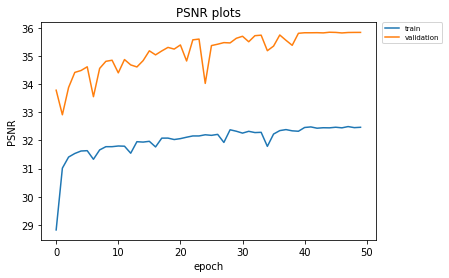

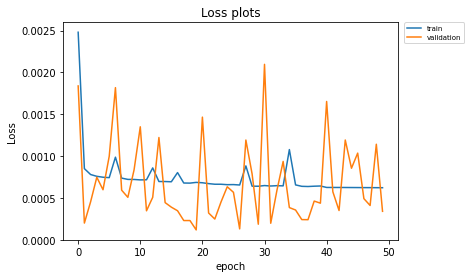

In [8]:
import argparse
import os
import copy

import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm


if __name__ == '__main__':
    train_file = "/content/drive/MyDrive/ML Project/91-image_x2.h5"
    eval_file = "/content/drive/MyDrive/ML Project/Set5_x2.h5"
    scale = 1
    outputs_dir = "output_espcn"
    lr = 0.001
    batch_size = 16
    num_epochs = 50
    num_workers = 8
    seed = 123

    outputs_dir = os.path.join(outputs_dir, 'x{}'.format(scale))

    if not os.path.exists(outputs_dir):
        os.makedirs(outputs_dir)

    cudnn.benchmark = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    torch.manual_seed(seed)

    model = ESPCN(scale_factor=scale).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam([
        {'params': model.first_part.parameters()},
        {'params': model.last_part.parameters(), 'lr': lr * 0.1}
    ], lr=lr)

    train_dataset = TrainDataset(train_file)
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True)
    eval_dataset = EvalDataset(eval_file)
    eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_psnr = 0.0

    epoch_train_psnrs = []
    epoch_val_psnrs = []

    epoch_train_losses = []
    epoch_val_losses = []

    for epoch in range(num_epochs):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr * (0.1 ** (epoch // int(num_epochs * 0.8)))

        model.train()
        epoch_losses_training = AverageMeter()
        epoch_psnr_training = AverageMeter()

        with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size), ncols=80) as t:
            t.set_description('epoch: {}/{}'.format(epoch, num_epochs - 1))

            for data in train_dataloader:
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                preds = model(inputs)

                loss = criterion(preds, labels)

                epoch_losses_training.update(loss.item(), len(inputs))
                epoch_psnr_training.update(calc_psnr(preds, labels), len(inputs))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                t.set_postfix(loss='{:.6f}'.format(epoch_losses_training.avg))
                t.update(len(inputs))


        epoch_train_losses.append(epoch_losses_training.avg)
        epoch_train_psnrs.append(epoch_psnr_training.avg)

        torch.save(model.state_dict(), os.path.join(outputs_dir, 'epoch_{}.pth'.format(epoch)))

        model.eval()

        epoch_psnr_val = AverageMeter()
        epoch_losses_val = AverageMeter()

        for data in eval_dataloader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                preds = model(inputs).clamp(0.0, 1.0)

            epoch_psnr_val.update(calc_psnr(preds, labels), len(inputs))
            epoch_losses_val.update(loss.item(), len(inputs))

        print('eval psnr: {:.2f}'.format(epoch_psnr_val.avg))
        epoch_val_psnrs.append(epoch_psnr_val.avg)
        epoch_val_losses.append(epoch_losses_val.avg)

        if epoch_psnr_val.avg > best_psnr:
            best_epoch = epoch
            best_psnr = epoch_psnr_val.avg
            best_weights = copy.deepcopy(model.state_dict())

    print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
    torch.save(best_weights, os.path.join(outputs_dir, 'best.pth'))


    from matplotlib import pyplot as plt
    epoch_train_psnrs_values = [x.detach().numpy() for x in epoch_train_psnrs]
    epoch_val_psnrs_values = [x.detach().numpy() for x in epoch_val_psnrs]
    plt.plot(epoch_train_psnrs_values)
    plt.plot(epoch_val_psnrs_values)
    plt.title("PSNR plots")
    plt.ylabel("PSNR")
    plt.xlabel("epoch")
    plt.legend(
        ["train", "validation"],
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        fontsize="x-small",
    )

    plt.savefig("/content/drive/MyDrive/ML Project/ESPCN_Model_PSNR.png", bbox_inches="tight", dpi=600)
    plt.show()

    plt.plot(epoch_train_losses)
    plt.plot(epoch_val_losses)
    plt.title("Loss plots")
    plt.ylabel("Loss")
    plt.xlabel("epoch")
    plt.legend(
        ["train", "validation"],
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        fontsize="x-small",
    )

    plt.savefig("/content/drive/MyDrive/ML Project/ESPCN_Model_MSE_loss.png", bbox_inches="tight", dpi=600)
    plt.show()